# Data Augmentations for Supervised Semantic Segmentation

Michael Mommert, Stuttgart University of Applied Sciences, 2025

This Notebook introduces different data augmentation methods related to the semantic segmentation of Sentinel-2 satellite images. This Notebook builds on the Notebook ["Supervised Semantic Segmentation with a UNet for Sentinel-2 Satellite Imagery"](https://github.com/Hochschule-fuer-Technik-Stuttgart/teaching-mommert/blob/main/remote_sensing/segmentation/lulc_unet/lulc_unet.ipynb); please refer to that Notebook for additional explanations.

In [4]:
%pip install numpy \
    scipy \
    pandas \
    matplotlib \
    rasterio \
    scikit-learn \
    torch \
    torchmetrics \
    tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 9.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [11]:
# system level modules for handling files and file structures
import os
import tarfile
import copy

# scipy ecosystem imports for numerics, data handling and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import ConfusionMatrixDisplay

# pytorch and helper modules
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics import JaccardIndex, F1Score

# utils
from tqdm.notebook import tqdm

# rasterio for reading in satellite image data
import rasterio

## Data Download


We download the *ben-ge-800* dataset and unpack it:

In [8]:
!wget https://zenodo.org/records/12941231/files/ben-ge-800.tar.gz?download=1 -O ben-ge-800.tar.gz

tarfile = tarfile.open('ben-ge-800.tar.gz')  # open ben-ge-800 tarball
tarfile.extractall('./', filter='data')  # extract tarball

data_base_path = 'ben-ge-800'  # set data directory

--2025-04-04 12:05:30--  https://zenodo.org/records/12941231/files/ben-ge-800.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 183201083 (175M) [application/octet-stream]
Saving to: ‘ben-ge-800.tar.gz’

ben-ge-800.tar.gz   100%[===================>] 174,71M  7,05MB/s    in 24s     

2025-04-04 12:05:54 (7,19 MB/s) - ‘ben-ge-800.tar.gz’ saved [183201083/183201083]



**ben-ge-800** contains samples for 800 locations with co-located Sentinel-1 SAR data, Sentinel-2 multispectral data, elevation data, land-use/land-cover data, as well as environmental data. **ben-ge-800** is a subset of the much larger **ben-ge** dataset (see [https://github.com/HSG-AIML/ben-ge](https://github.com/HSG-AIML/ben-ge) for details.) We deliberately use a very small subset of **ben-ge** to enable reasonable runtimes for the examples shown in this tutorial.

The environment is now set up and the data in place. Before we look at ways to augment our dataset, we fix some random seeds to obtain reproduceable results:

In [9]:
np.random.seed(42)     # sets the seed value in Numpy
torch.manual_seed(42)  # sets the seed value in Pytorch\
torch.cuda.manual_seed(42)

## Data Augmentations

Let's extract a single image to visualize different data augmentation methods.

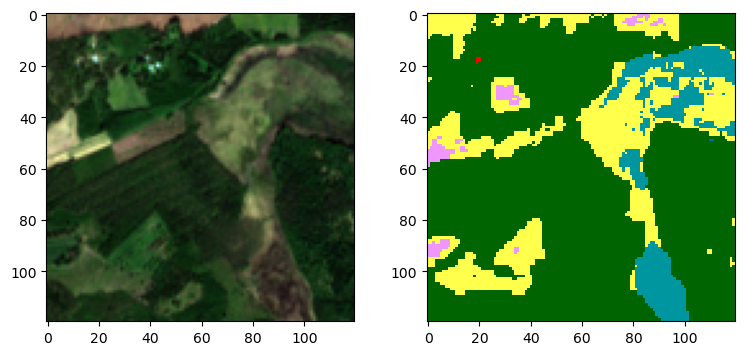

In [20]:
sen2_path = 'ben-ge-800/sentinel-2/'
ewc_path = 'ben-ge-800/esaworldcover/'
filename = 'S2B_MSIL2A_20180525T94030_7_51'
bands = ['B04', 'B03', 'B02']  # R, G, B

# define ESA WorldCover colormap
COLOR_CATEGORIES = [
    (0, 100, 0),
    (255, 187, 34),
    (255, 255, 76),
    (240, 150, 255),
    (250, 0, 0),
    (180, 180, 180),
    (240, 240, 240),
    (0, 100, 200),
    (0, 150, 160),
    (0, 207, 117),
    (250, 230, 160)]
cmap_all = mpl.colors.ListedColormap(np.array(COLOR_CATEGORIES)/255.)

# define ESA WorldCover class label names
ewc_label_names = ["tree_cover", "shrubland", "grassland", "cropland", "built-up",
                   "bare/sparse_vegetation", "snow_and_ice","permanent_water_bodies",
                   "herbaceous_wetland", "mangroves","moss_and_lichen"]

# read in image data
data = []
for band in bands:
    dataset = rasterio.open(os.path.join(sen2_path, filename, filename+'_'+band+'.tif'))
    data.append(dataset.read(1))
img = np.dstack(data)

# we normalize the pixel values in such a way that they range from 0 (min) to 1 (max)
img = (img-np.min(img, axis=(0,1)))/(np.max(img, axis=(0,1)) - np.min(img, axis=(0,1)))


# read in and pre-process ESA WorldCover land-use/land-cover data
dataset = rasterio.open(os.path.join(ewc_path, filename+'_esaworldcover.tif'))
ewc_data = dataset.read(1)
ewc_mask = ewc_data.astype(float)
ewc_mask[ewc_mask == 100] = 110  # fix some irregular class labels
ewc_mask[ewc_mask == 95] = 100   # fix some irregular class labels
ewc_mask = ewc_mask / 10 - 1 # transform to scale [0, 11]

# plot the image alongside the lulc data
f, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].imshow(img)
ax[1].imshow(ewc_mask, cmap=cmap_all, vmin=0, vmax=11, interpolation='nearest')

We can now use the data stored in `img` (image data) and `ewc_mask` (lulc data) to apply different transformations. One important detail to keep in mind is that we have to apply the same transformation that we apply to the input (image) data also to the label (lulc) data.

For instance, we can mirror the image upside-down or left-to-right:

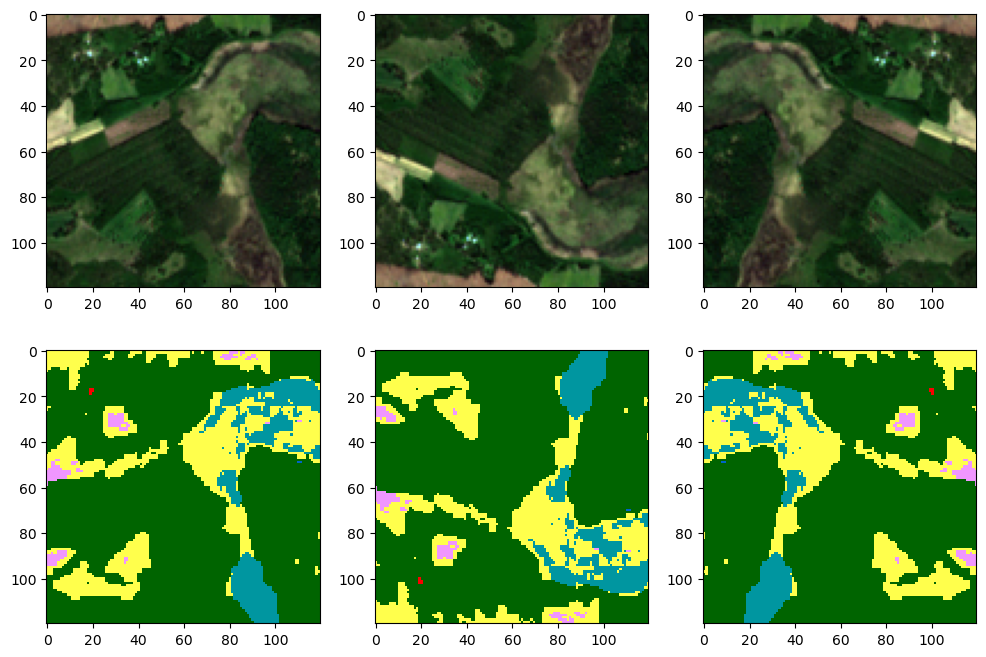

In [23]:
f, ax = plt.subplots(2, 3, figsize=(12, 8))

# top row: image data

# plot the original image
ax[0][0].imshow(img)

# plot the upside-down version of the image
ax[0][1].imshow(np.flipud(img))

# plot the left-right-flipped version of the image
ax[0][2].imshow(np.fliplr(img))

# bottom row: label data

# plot the original lulc mask
ax[1][0].imshow(ewc_mask, cmap=cmap_all, vmin=0, vmax=11, interpolation='nearest')

# plot the upside-down version of the lulc mask
ax[1][1].imshow(np.flipud(ewc_mask), cmap=cmap_all, vmin=0, vmax=11, interpolation='nearest')

# plot the left-right-flipped version of the lulc mask
ax[1][2].imshow(np.fliplr(ewc_mask), cmap=cmap_all, vmin=0, vmax=11, interpolation='nearest')

Note how the information in the image and label data line up well.

In the same way, we can rotate our image by integer multiples of 90 degrees. Naturally, there are only 4 distinct possible orientations:

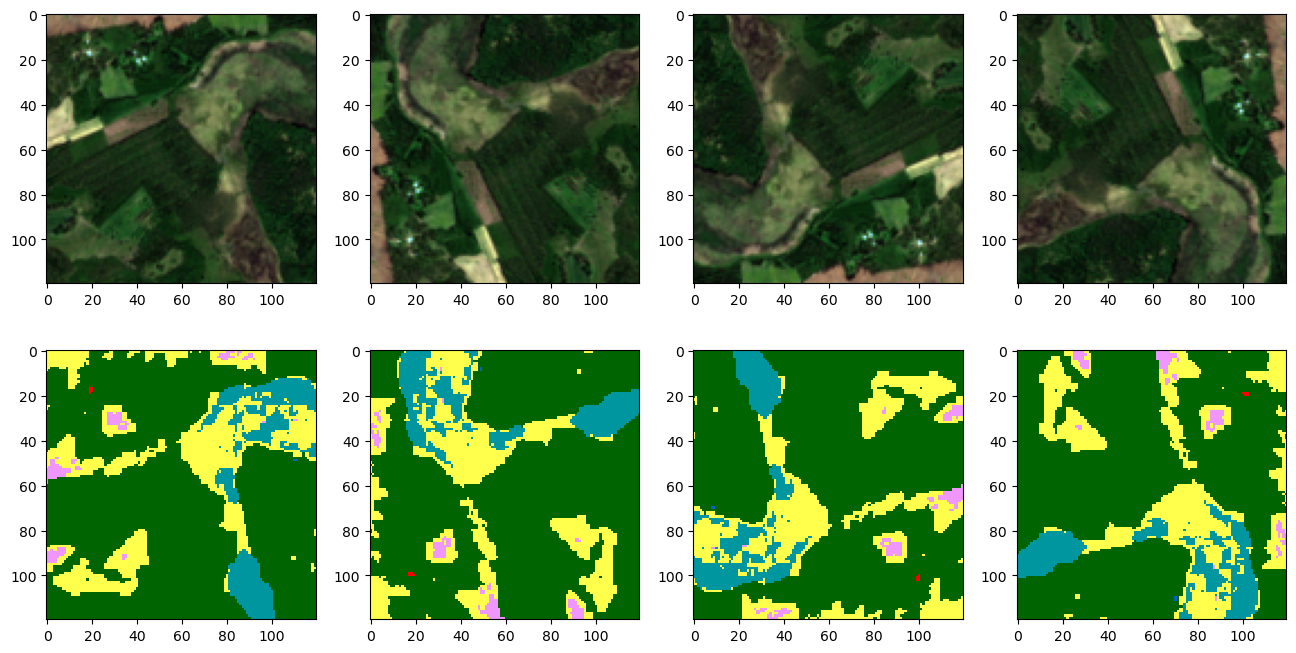

In [24]:
f, ax = plt.subplots(2, 4, figsize=(16, 8))

# top row: image data

# original (unrotated) image
ax[0][0].imshow(img)

# rotate by 90 degrees
ax[0][1].imshow(np.rot90(img, 1))

# rotate by 180 degrees
ax[0][2].imshow(np.rot90(img, 2))

# rotate by 270 degrees
ax[0][3].imshow(np.rot90(img, 3))


# bottom row: label data

# original (unrotated) labels
ax[1][0].imshow(ewc_mask, cmap=cmap_all, vmin=0, vmax=11, interpolation='nearest')

# rotate by 90 degrees
ax[1][1].imshow(np.rot90(ewc_mask, 1), cmap=cmap_all, vmin=0, vmax=11, interpolation='nearest')

# rotate by 180 degrees
ax[1][2].imshow(np.rot90(ewc_mask, 2), cmap=cmap_all, vmin=0, vmax=11, interpolation='nearest')

# rotate by 270 degrees
ax[1][3].imshow(np.rot90(ewc_mask, 3), cmap=cmap_all, vmin=0, vmax=11, interpolation='nearest')


This is pretty straightforward and the images and masks line up nicely.

The question is now: how we are going to use these transformations in our model training pipeline?

The idea is to implement the transformations as a method in our Dataset class. Whenever we extract a sample from our dataset, a random set of transformations will be applied. This implies that we can apply several transformations at the same time.

**Question**: If we only consider image mirroring and rotations by integer multiples of 90 degrees, how many different transformations can we generate of the same image? 

Before we implement the transformation method, let's write it as a function to test and understand its functionality in detail.

In [33]:
def transform(img, ewc_mask):
    """Function that will apply random transformations to image and label data provided as parameters."""

    # randomize upside-down mirroring
    if np.random.rand() >= 0.5:
        img = np.flipud(img)
        ewc_mask = np.flipud(ewc_mask)

    # randomize left-right mirroring
    if np.random.rand() >= 0.5:
        img = np.fliplr(img)
        ewc_mask = np.fliplr(ewc_mask)

    # randomize number of rotations [0, 3]
    k = np.floor(np.random.rand()*4)
    img = np.rot90(img, k)
    ewc_mask = np.rot90(ewc_mask, k)

    return img, ewc_mask    

(120, 120, 3) (120, 120)


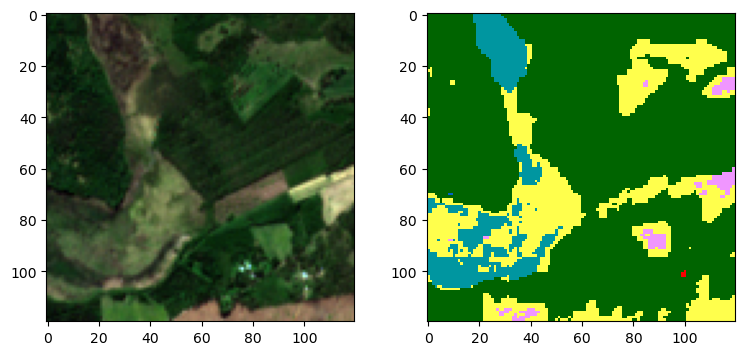

In [ ]:
# apply data augmentations
img_aug, ewc_mask_aug = transform(img, ewc_mask)

# plot the image alongside the lulc data
f, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].imshow(img_aug)
ax[1].imshow(ewc_mask_aug, cmap=cmap_all, vmin=0, vmax=11, interpolation='nearest')

Note how, in the above implementation, the individual transformation are completely independent from each other. Run the above code cell several times in a row. You will see a multitude of possible transformations for this single image.

We will use this effect to synthetically generate a much larger training data than the one we actually have at hand.

## Training Setup

In the following we will prepare the training. First, we will modify our existing dataset class that we implemented already in the Notebook ["Supervised Semantic Segmentation with a UNet for Sentinel-2 Satellite Imagery"](https://github.com/Hochschule-fuer-Technik-Stuttgart/teaching-mommert/blob/main/remote_sensing/segmentation/lulc_unet/lulc_unet.ipynb). We will add a method named `transform()`, which will perform the same transformation that we defined above. Note that the dataset class has only been changed in two places, which are highlighted for comparison.

In [99]:
class BENGE(Dataset):
    """A dataset class implementing the Sentinel-2 and ESAWorldCover data modalities, together with corresponding data augmentations."""
    def __init__(self,
                 data_dir=data_base_path,
                 split='train',
                 s2_bands=[2, 3, 4, 8]):
        """Dataset class constructor

        keyword arguments:
        data_dir -- string containing the path to the base directory of ben-ge dataset, default: ben-ge-800 directory
        split    -- string, describes the split to be instantiated, either `train`, `val` or `test`
        s2_bands -- list of Sentinel-2 bands to be extracted, default: all bands

        returns:
        BENGE object
        """
        super(BENGE, self).__init__()

        # store some definitions
        self.s2_bands = s2_bands
        self.data_dir = data_dir

        # read in relevant data files and definitions
        self.name = self.data_dir.split("/")[-1]
        self.split = split
        self.meta = pd.read_csv(f"{self.data_dir}/{self.name}_meta.csv", index_col='patch_id')

        # we use the first 500 samples for training, then 150 for validation and 150 for testing
        if split == 'train':
            self.meta = self.meta.iloc[0:500]
        if split == 'val':
            self.meta = self.meta.iloc[500:650]
        if split == 'test':
            self.meta = self.meta.iloc[650:800]


    def __getitem__(self, idx):
        """Return sample `idx` as dictionary from the dataset."""
        sample_info = self.meta.iloc[idx]
        patch_id = self.meta.index[idx]

        # retrieve Sentinel-2 data
        s2 = np.empty((4, 120, 120))
        for i, band in enumerate(self.s2_bands):
            with rio.open(f"{self.data_dir}/sentinel-2/{patch_id}/{patch_id}_B0{band}.tif") as dataset:
                data = dataset.read(1)
            if i < 3:
                s2[i,:,:] = data/3000  # normalize Sentinel-2 data
            else:
                s2[i,:,:] = data/6000  # normalize Sentinel-2 data

        # extract lulc data
        with rio.open(f"{self.data_dir}/esaworldcover/{patch_id}_esaworldcover.tif") as dataset:
            ewc_data = dataset.read(1)
        ewc_mask = ewc_data.astype(float)
        ewc_mask[ewc_mask == 100] = 110  # fix some irregular class labels
        ewc_mask[ewc_mask == 95] = 100   # fix some irregular class labels
        ewc_mask = ewc_mask / 10 - 1 # transform to scale [0, 11]

        # apply transformations -------------------------------------------- added for data augmentations
        s2, ewc_mask = self.transform(s2, ewc_mask)

        # create sample dictionary containing all the data
        sample = {
            #"patch_id": patch_id,  # Sentinel-2 id of this patch
            "s2": torch.from_numpy(s2.copy()).float(),  # Sentinel-2 data [4, 120, 120]
            "lulc": torch.from_numpy(ewc_mask.copy()).long(),  # ESA WorldCover lulc classes per pixel [120, 120]
            }

        return sample

    def __len__(self):
        """Return length of this dataset."""
        return self.meta.shape[0]

    # -------------------------------------------- added for data augmentations
    def transform(self, s2, ewc_mask):
        """Method that will apply random transformations to image and label data provided as parameters."""

        # randomize upside-down mirroring
        if np.random.rand() >= 0.5:
            s2 = np.flip(s2, axis=1)
            ewc_mask = np.flipud(ewc_mask)

        # randomize left-right mirroring
        if np.random.rand() >= 0.5:
            s2 = np.flip(s2, axis=2)
            ewc_mask = np.fliplr(ewc_mask)

        # randomize number of rotations [0, 3]
        k = np.floor(np.random.rand()*4)
        s2 = np.rot90(s2, k, axes=(1,2))
        ewc_mask = np.rot90(ewc_mask, k)

        return s2, ewc_mask 
        

    def display(self, idx, pred=None):
        """Method to display a data sample, consisting of the Sentinel-2 image and lulc map, and potentially a corresponding prediction.

        positional arguments:
        idx -- sample index

        keyword arguments:
        pred -- prediction tensor
        """

        # retrieve sample
        sample = self[idx]

        if pred is None:
            f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
        else:
            f, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))

        # display Sentinel-2 image
        img_rgb = np.dstack(sample['s2'][0:3].numpy()[::-1])  # extract RGB, reorder, and perform a deep stack (shape: 120, 120, 3)
        img_rgb = np.clip((img_rgb-np.percentile(img_rgb, 1))/(np.percentile(img_rgb, 99)-np.percentile(img_rgb, 1)), 0, 1)
        ax[0].imshow(img_rgb)
        ax[0].set_title('Sentinel-2')
        ax[0].axis('off')

        # display lulc map
        ax[1].imshow(sample['lulc'], cmap=cmap_all, vmin=0, vmax=11, interpolation='nearest')
        ax[1].set_title('Ground Truth')
        ax[1].axis('off')

        # display prediction, if available
        if pred is not None:
            ax[2].imshow(pred, cmap=cmap_all, vmin=0, vmax=11, interpolation='nearest')
            ax[2].set_title('Prediction')
            ax[2].axis('off')


We can now instantiate the different splits for this dataset:

In [100]:
train_data = BENGE(split='train')
val_data = BENGE(split='val')
test_data = BENGE(split='test')

len(train_data), len(val_data), len(test_data)

(500, 150, 150)

We display a single sample from our dataset (call this cell multiple times to make sure the alignment between image and label data is correct):

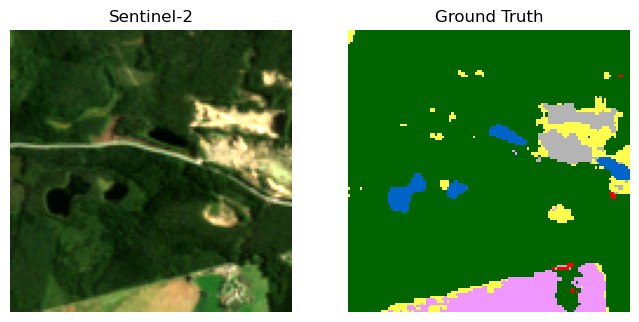

In [105]:
train_data.display(2)

For Neural Network training we have to define data loaders. When we do so, we have to define the batch size, which is typically limited by the GPU RAM during training. For evaluation purposes, we can typically pick a larger batch size, since we need less memory.

In [ ]:
train_batchsize = 64
eval_batchsize = 512

def collate_fn(batch):
    """This function combines the individual samples in a batch into the right format."""
    return {'s2': torch.stack([x['s2'] for x in batch]),
            'lulc': torch.stack([x['lulc'] for x in batch])}

train_dataloader = DataLoader(train_data, batch_size=train_batchsize, num_workers=2, pin_memory=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=eval_batchsize, num_workers=2, pin_memory=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=eval_batchsize, num_workers=2, pin_memory=True, collate_fn=collate_fn)

## Model Implementation

We use an implementation of the [UNet architecture](https://arxiv.org/pdf/1505.04597) for our semantic segmentation problem. The UNet is a fully convolutional encoder-decoder architecture that is designed to enable data-efficient semantic segmentation results. While other architectures are available, the UNet is still able to provide state-of-the-art results for many segmentation problems.

The exact implementation that we are using has been adopted from https://github.com/milesial/Pytorch-UNet:

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            #nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
            #nn.LeakyReLU(negative_slope=0.3, inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# the model will have as input images with 4 bands (B, G, R, NIR)
# the output will consist of 12 classes (multiclass problem)
model = UNet(n_channels=4, n_classes=12)

## Training and Validation

First of all, let's verify if a GPU is available on our compute machine. If not, the CPU will be used instead.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Device used: {}'.format(device))

Before we can implement the training pipeline we have to define two more things: a Loss function and an optimizer that will update our model weights during training. We also define our evaluation metric, for which we use the accuracy score.

In [ ]:
# we will use the cross entropy loss for our multiclass problem
criterion = nn.CrossEntropyLoss()

# we will use the Adam optimizer
learning_rate = 0.001
opt = optim.Adam(params=model.parameters(), lr=learning_rate)

# we instantiate the iou and f1 metrics for multiclass scenarios
iou = JaccardIndex(task="multiclass", num_classes=12).to(device)
f1 = F1Score(task="multiclass", num_classes=12).to(device)

Now, we have to move the model and the loss function on the GPU, since the computationally heavy work will be conducted there.

In [ ]:
model.to(device)
criterion.to(device)
iou.to(device)

Finally, we can implement our training pipeline.


In [ ]:
epochs = 10

train_losses_epochs = []
val_losses_epochs = []
train_ious_epochs = []
val_ious_epochs = []
train_f1_epochs = []
val_f1_epochs = []

for ep in range(epochs):

    train_losses = []
    val_losses = []
    train_ious = []
    val_ious = []
    train_f1 = []
    val_f1 = []

    # we perform training for one epoch
    model.train()   # it is very important to put your model into training mode!
    for samples in (pbar := tqdm(train_dataloader)):
        # we extract the input data (Sentinel-2)
        x = samples['s2'].to(device)

        # now we extract the target (lulc class) and move it to the gpu
        y = samples['lulc'].to(device)

        # we make a prediction with our model
        output = model(x)

        # we reset the graph gradients
        model.zero_grad()

        # we determine the classification loss
        loss_train = criterion(output, y)

        # we run a backward pass to comput the gradients
        loss_train.backward()

        # we update the network paramaters
        opt.step()

        # we write the mini-batch loss and accuracy into the corresponding lists
        train_losses.append(loss_train.detach().cpu())
        train_ious.append(iou(torch.argmax(output, dim=1), y).detach().cpu())
        train_f1.append(f1(torch.argmax(output, dim=1), y).detach().cpu())

        pbar.set_description("loss={:.4f}, iou={:.4f}, f1={:.4f}".format(train_losses[-1], train_ious[-1], train_f1[-1]))

    # we evaluate the current state of the model on the validation dataset
    model.eval()   # it is very important to put your model into evaluation mode!
    with torch.no_grad():
        for samples in tqdm(val_dataloader):
            # we extract the input data (Sentinel-2)
            x = samples['s2'].to(device)

            # now we extract the target (lulc class) and move it to the gpu
            y = samples['lulc'].to(device)

            # we make a prediction with our model
            output = model(x)

            # we determine the classification loss
            loss_val = criterion(output, y)

            # we write the mini-batch loss and accuracy into the corresponding lists
            val_losses.append(loss_val.detach().cpu())
            val_ious.append(iou(torch.argmax(output, dim=1), y).detach().cpu())
            val_f1.append(f1(torch.argmax(output, dim=1), y).detach().cpu())

    train_losses_epochs.append(np.mean(train_losses))
    train_ious_epochs.append(np.mean(train_ious))
    train_f1_epochs.append(np.mean(train_f1))
    val_losses_epochs.append(np.mean(val_losses))
    val_ious_epochs.append(np.mean(val_ious))
    val_f1_epochs.append(np.mean(val_f1))

    print("epoch {}: train: loss={:.4f}, iou={:.4f}, f1={:.4f}; val: loss={:.4f}, iou={:.4f}, f1={:.4f}".format(
        ep, train_losses_epochs[-1], train_ious_epochs[-1], train_f1_epochs[-1],
        val_losses_epochs[-1], val_ious_epochs[-1], val_f1_epochs[-1]))

Training progress looks good: train and validation losses are decreasing, iou and f1 scores are increasing.

Let's plot the available metrics as a function of the number of training iterations:

In [ ]:
f, ax = plt.subplots(1, 3, sharex=True, figsize=(17,5))

ax[0].plot(np.arange(1, len(train_losses_epochs)+1), train_losses_epochs, label='Train', color='blue')
ax[0].plot(np.arange(1, len(val_losses_epochs)+1), val_losses_epochs, label='Val', color='red')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(np.arange(1, len(train_ious_epochs)+1), train_ious_epochs, label='Train', color='blue')
ax[1].plot(np.arange(1, len(val_ious_epochs)+1), val_ious_epochs, label='Val', color='red')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('IoU')
ax[1].legend()

ax[2].plot(np.arange(1, len(train_f1_epochs)+1), train_f1_epochs, label='Train', color='blue')
ax[2].plot(np.arange(1, len(val_f1_epochs)+1), val_f1_epochs, label='Val', color='red')
ax[2].set_xlabel('Iterations')
ax[2].set_ylabel('F1')
ax[2].legend()

The model learns. After 10 training epochs we find a validation dataset iou of XXX and f1 score of XXX. Without data augmentations, we found an iou of 0.3 and an f1 score of 0.66, so that means....

## Evaluation

Let's also evaluate the model on the test dataset:

In [ ]:
test_ious = []
test_f1 = []
predictions = []
groundtruths = []

model.eval()   # it is very important to put your model into evaluation mode!
with torch.no_grad():
    for samples in tqdm(test_dataloader):
        x = samples['s2'].to(device)

        # now we extract the target (lulc class) and move it to the gpu
        y = samples['lulc'].to(device)
        groundtruths.append(y.cpu())

        # we make a prediction with our model
        output = model(x)
        predictions.append(np.argmax(output.cpu().numpy(), axis=1))
        # the argmax finds the class (channel) with the highest output

        # we determine the classification loss
        loss_val = criterion(output, y)

        # we write the mini-nbatch loss and accuracy into the corresponding lists
        test_ious.append(iou(torch.argmax(output, dim=1), y).cpu().numpy())
        test_f1.append(f1(torch.argmax(output, dim=1), y).cpu().numpy())


print('test dataset ious:', np.mean(test_ious))
print('test dataset f1:', np.mean(test_f1))

# flatten predictions and groundtruths
predictions = np.concatenate(predictions).ravel()
groundtruths = np.concatenate(groundtruths).ravel()


The results are XXX

Keep in mind that we synthetically increased the size of our dataset. Therefore, it might take longer for the model to learn something useful.

**Exercise**: Increase the number of training epochs and see whether the model using data augmentations can beat the baseline model.

In [ ]:
# use this cell for the exercise

**Exercise**: Implement an additional data transformation that randomly permutates the spectral bands of our imaging data. Will this augmentation improce the performance of the trained model?

In [ ]:
# use this cell for the exercise